In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import datetime
import seaborn as sns

In [2]:
def calculateEnergyGenerated(startDate,endData,keepRes = False):
    """ generates the ROR electricity plant for a start date to an end date
    start and end dates: must be in datetime formats
    keepRes: 
    if false, returns a single value for how much energy was generated (joules) for time span
    if true, returns the energy generated at each 15 minute resolution (Watts) for time span
    
    """
    dischargeData = df[df.Date.between(startDate, endData)]['Mass Flow (ft^3/s)'] #reading in data
    dischargeData = np.array(dischargeData) * footCubeToMeter#in m^3/s
    inputVelocityData = dischargeData / area #now in m/s
    inputVelocityData = np.where(inputVelocityData > 10, 10, inputVelocityData) #capping max velocity at 10 m/s
    massFlowData =  dischargeData  * density #now in kg/s
    workGenerated = efficiency * .5 * massFlowData * (inputVelocityData *inputVelocityData) #in joules / second or watts
    energyGenerated = workGenerated * timeGap #(converting to joules generated for each 15 minute period)
    
    if keepRes: return workGenerated #returning in watt format
    else: return (np.sum(energyGenerated)) #returning in watt-hours or in joules

In [3]:
#setting constants
footToMeter = 0.3048000 # m/ft
footCubeToMeter = footToMeter ** 3 #m^3/ft^3
length = 150 * footToMeter #feet to meters
depth = 18 * footToMeter #feet to meters
area = math.pi *length * depth / 2 #in m^2
density = 997 # in kg/m^3
efficiency = .81

Average generation over years: 756950760.3958917


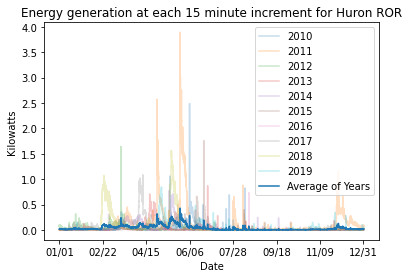

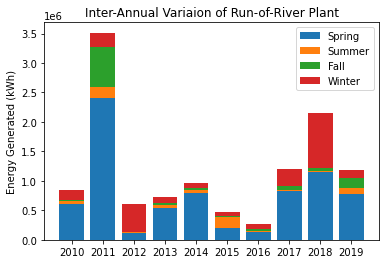

In [5]:
##########################################
#Data comes in from the'discharge_huron_river_data.csv' in 15 minute intervals from 2010-01-01 to 2019-12-31

##########################################

 #reading in data
df = pd.read_csv("Cleaned_Huron_River_Discharge_Data.csv",parse_dates = True)

#converting to datetime fromat so we can index into a specific year and removing leap year day
df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d %H:%M')
df = df[~((df["Date"].dt.month == 2) & (df["Date"].dt.day == 29))]

#defining constants and start and end years
year = 2010
endYear = 2020
timeGap = 15 * 60 #15 minutes converted to seconds for each of the csv entries
wattHourConversion = 60 * 60 #how many seconds are in 1 hour
timesThru = 0

#defining total generation dataset, 5 rows for each year: format goes total generation then spring,summer,fall,winter
totalGenerationDataset = np.zeros((5,endYear-year))
highResData = np.zeros((endYear-year,8760*4))
while year < 2020:
    #setting up dates for getting data from january 1st to december 31st
    start_date = pd.to_datetime('01/01/%s' % (year))
    end_date = pd.to_datetime('12/31/%s 23:59' % (year))
    
    #spring season date range
    springStart =  pd.to_datetime('03/20/%s 00:00' % (year))
    springEnd = pd.to_datetime('06/19/%s 23:59' % (year))
    
    #summer season date range 
    summerStart =  pd.to_datetime('06/20/%s 00:00' % (year))
    summerEnd = pd.to_datetime('09/21/%s 23:59' % (year))
    
    #fall season date range
    fallStart =  pd.to_datetime('09/22/%s 00:00' % (year))
    fallEnd = pd.to_datetime('12/20/%s 23:59' % (year))
    
    #winter season date range
    winterStart = pd.to_datetime('12/21/%s 00:00' % (year))
    winterEnd = pd.to_datetime('03/19/%s 23:59' % (year))

    



    #looking at seasons over the years
    totalGenerationDataset[0][timesThru] = calculateEnergyGenerated(start_date,end_date) #full year data
    totalGenerationDataset[1][timesThru] = calculateEnergyGenerated(springStart,springEnd) #spring data
    totalGenerationDataset[2][timesThru] = calculateEnergyGenerated(summerStart,summerEnd) #summer data
    totalGenerationDataset[3][timesThru] = calculateEnergyGenerated(fallStart,fallEnd) #fall data

    #winter data, what we did was add winter from end of year and winter from start of year
    totalGenerationDataset[4][timesThru] = calculateEnergyGenerated(winterStart,end_date) #winter to end of year
    totalGenerationDataset[4][timesThru] += calculateEnergyGenerated(start_date,winterEnd) #adding on from january 1st to start of spring
    
    highResData[timesThru] = calculateEnergyGenerated(start_date,end_date,keepRes = True) /1000 #full year data converted to Kilowatts from Watts
    
    plt.plot(highResData[timesThru],label=year,alpha=.25) #converting to kW
    year += 1
    timesThru += 1

#average value of total year ROR generation
print("Average generation over years: %s" % (np.average(totalGenerationDataset[1][:])))

#this graph shows what the expected watt hour generation would be for the run of river plant for each 15 minute discharge period
plt.title("Energy generation at each 15 minute increment for Huron ROR")
plt.ylabel("Kilowatts")
plt.xlabel("Date")
plt.plot(np.mean(highResData,axis=0),label="Average of Years")
plt.legend()
# Get locations and labels
locs, labels = plt.xticks()
#custom location for labels in line with automatically generated tick locations
plt.xticks(locs[1:9], ["01/01","02/22","04/15","06/06","07/28","09/18","11/09","12/31"]) 
plt.show()

#barchart graph
years = ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019')
y_pos = np.arange(len(years))

#seasons combined together with no differentiation between seasons
'''
plt.bar(y_pos, totalGenerationDataset[0], align='center',label = "Total Generation")
plt.xticks(y_pos, years)
plt.ylabel('Total Energy Generated (Joules)')
plt.title('Total Energy Generated for each Year')# of Run of River Power Plant at Huron River')
plt.legend()
totalGenerationDataset = totalGenerationDataset / 1000 #converting to kWh
'''
totalGenerationDataset = totalGenerationDataset / 1000 #converting watt hours to kWh
#stacking bar chart values
plt.bar(y_pos, totalGenerationDataset[1], align='center',label = "Spring")
plt.bar(y_pos, totalGenerationDataset[2], align='center',label = "Summer",bottom=totalGenerationDataset[1])
plt.bar(y_pos, totalGenerationDataset[3], align='center',label = "Fall",bottom=(totalGenerationDataset[1]+totalGenerationDataset[2]))
plt.bar(y_pos, totalGenerationDataset[4], align='center',label="Winter",bottom=(totalGenerationDataset[1]+totalGenerationDataset[2]+totalGenerationDataset[3]))

#plotting bar chart
plt.xticks(y_pos, years)
plt.ylabel('Energy Generated (kWh)')
plt.title('Inter-Annual Variaion of Run-of-River Plant')# of Run of River Power Plant at Huron River')
plt.legend()
plt.show()